# Library

In [ ]:
%%capture
!pip install top2vec
!pip install top2vec[sentence_transformers]
!python -m nltk.downloader all
!pip install bertopic
!pip install distributed==2021.9.0
!pip install lda2vec
!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis
!pip install deberta
!pip install flair
!pip install contextualized_topic_models

# Datasets  

In [ ]:
import pandas as pd

# only 20'000 random articles
# url_arxiv_subset = 'https://raw.githubusercontent.com/KvindtEva/GRADUATE-WORK/main/arxiv_subset.csv'
# only 10'000 random clean abstract
url_arxiv_subset = 'https://raw.githubusercontent.com/KvindtEva/GRADUATE-WORK/main/arxiv_clean_abstract_10k.csv'
df = pd.read_csv(url_arxiv_subset, index_col=0)
df.head()

,authors,title,category,abstract,abstract_word_count,clean_abstract
394700,Karri I. I. Koljonen and Talvikki Hovatta,ALMA/NICER observations of GRS 1915+105 indica...,['astro-ph.HE'],GRS 1915+105 is a transient black hole X-ray...,271,gr transient black hole binari consist emit ed...
77110,"Ze-Rui Liang, Xian-Qiao Yu",The perturbative QCD predictions for the decay...,['hep-ph'],"In this work, we calculate the branching rat...",150,in work calcul branch ratio cp violat decay mo...
520591,Christoph Bock,On five-dimensional contact solvmanifolds,['math.SG'],Any five-dimensional solvmanifold $\Gamma \b...,24,ani solvmanifold g contact lattic connect lie ...
105361,"Jennifer E. Starling, Jared S. Murray, Patrici...",Targeted Smooth Bayesian Causal Forests: An an...,['stat.AP'],We introduce Targeted Smooth Bayesian Causal...,149,we introduc target smooth bayesian causal fore...
228598,"O. Linder (1), E. Fable (1), F. Jenko (1), G. ...",Self-consistent modeling of runaway electron g...,['physics.plasm-ph'],We present the first successful simulation o...,196,we present first success simul induc disrupt a...


# Cleaning dataset


In [ ]:
# from nltk.tokenize import word_tokenize
# from string import punctuation
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

# def clean_text(text):
#   # delete punctuation and stop-words
#   noise = stopwords.words('english') + list(punctuation)
#   # stemming words
#   porter = PorterStemmer()
#   # tokenize, lowercase and delete numeric
#   text = [porter.stem(word.lower()) for word in word_tokenize(text) if not word in noise and word.isalpha()]  
#   # return string
#   return ' '.join(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# df['clean_abstract'] = df['abstract'].apply(lambda x: clean_text(x))
# df[:10000].to_csv('arxiv_clean_abstract_10k.csv')

# LDA  
Learning time: 195 sec  
Num of topics: 20-30 (manually configured; optimal number can be finded by the highest coherence score)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from time import time

data_samples = list(df['clean_abstract'])

In [ ]:

n_topics = 30

count_vectorizer = CountVectorizer(max_df=0.85)
tf = count_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(n_components=n_topics, 
                                # max_iter=5,
                                # learning_method='online',
                                # learning_offset=50.,
                                random_state=42)
t0=time()
print('lda fitting')
lda.fit(tf)
print('LDA fitting is done, time elapsed:', time()-t0, )

print('plotting')
tf_feature_names = count_vectorizer.get_feature_names()

lda fitting
LDA fitting is done, time elapsed: 195.9909794330597
plotting


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# probabilities of topics for documents
x = lda.fit_transform(tf)

In [ ]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 6, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

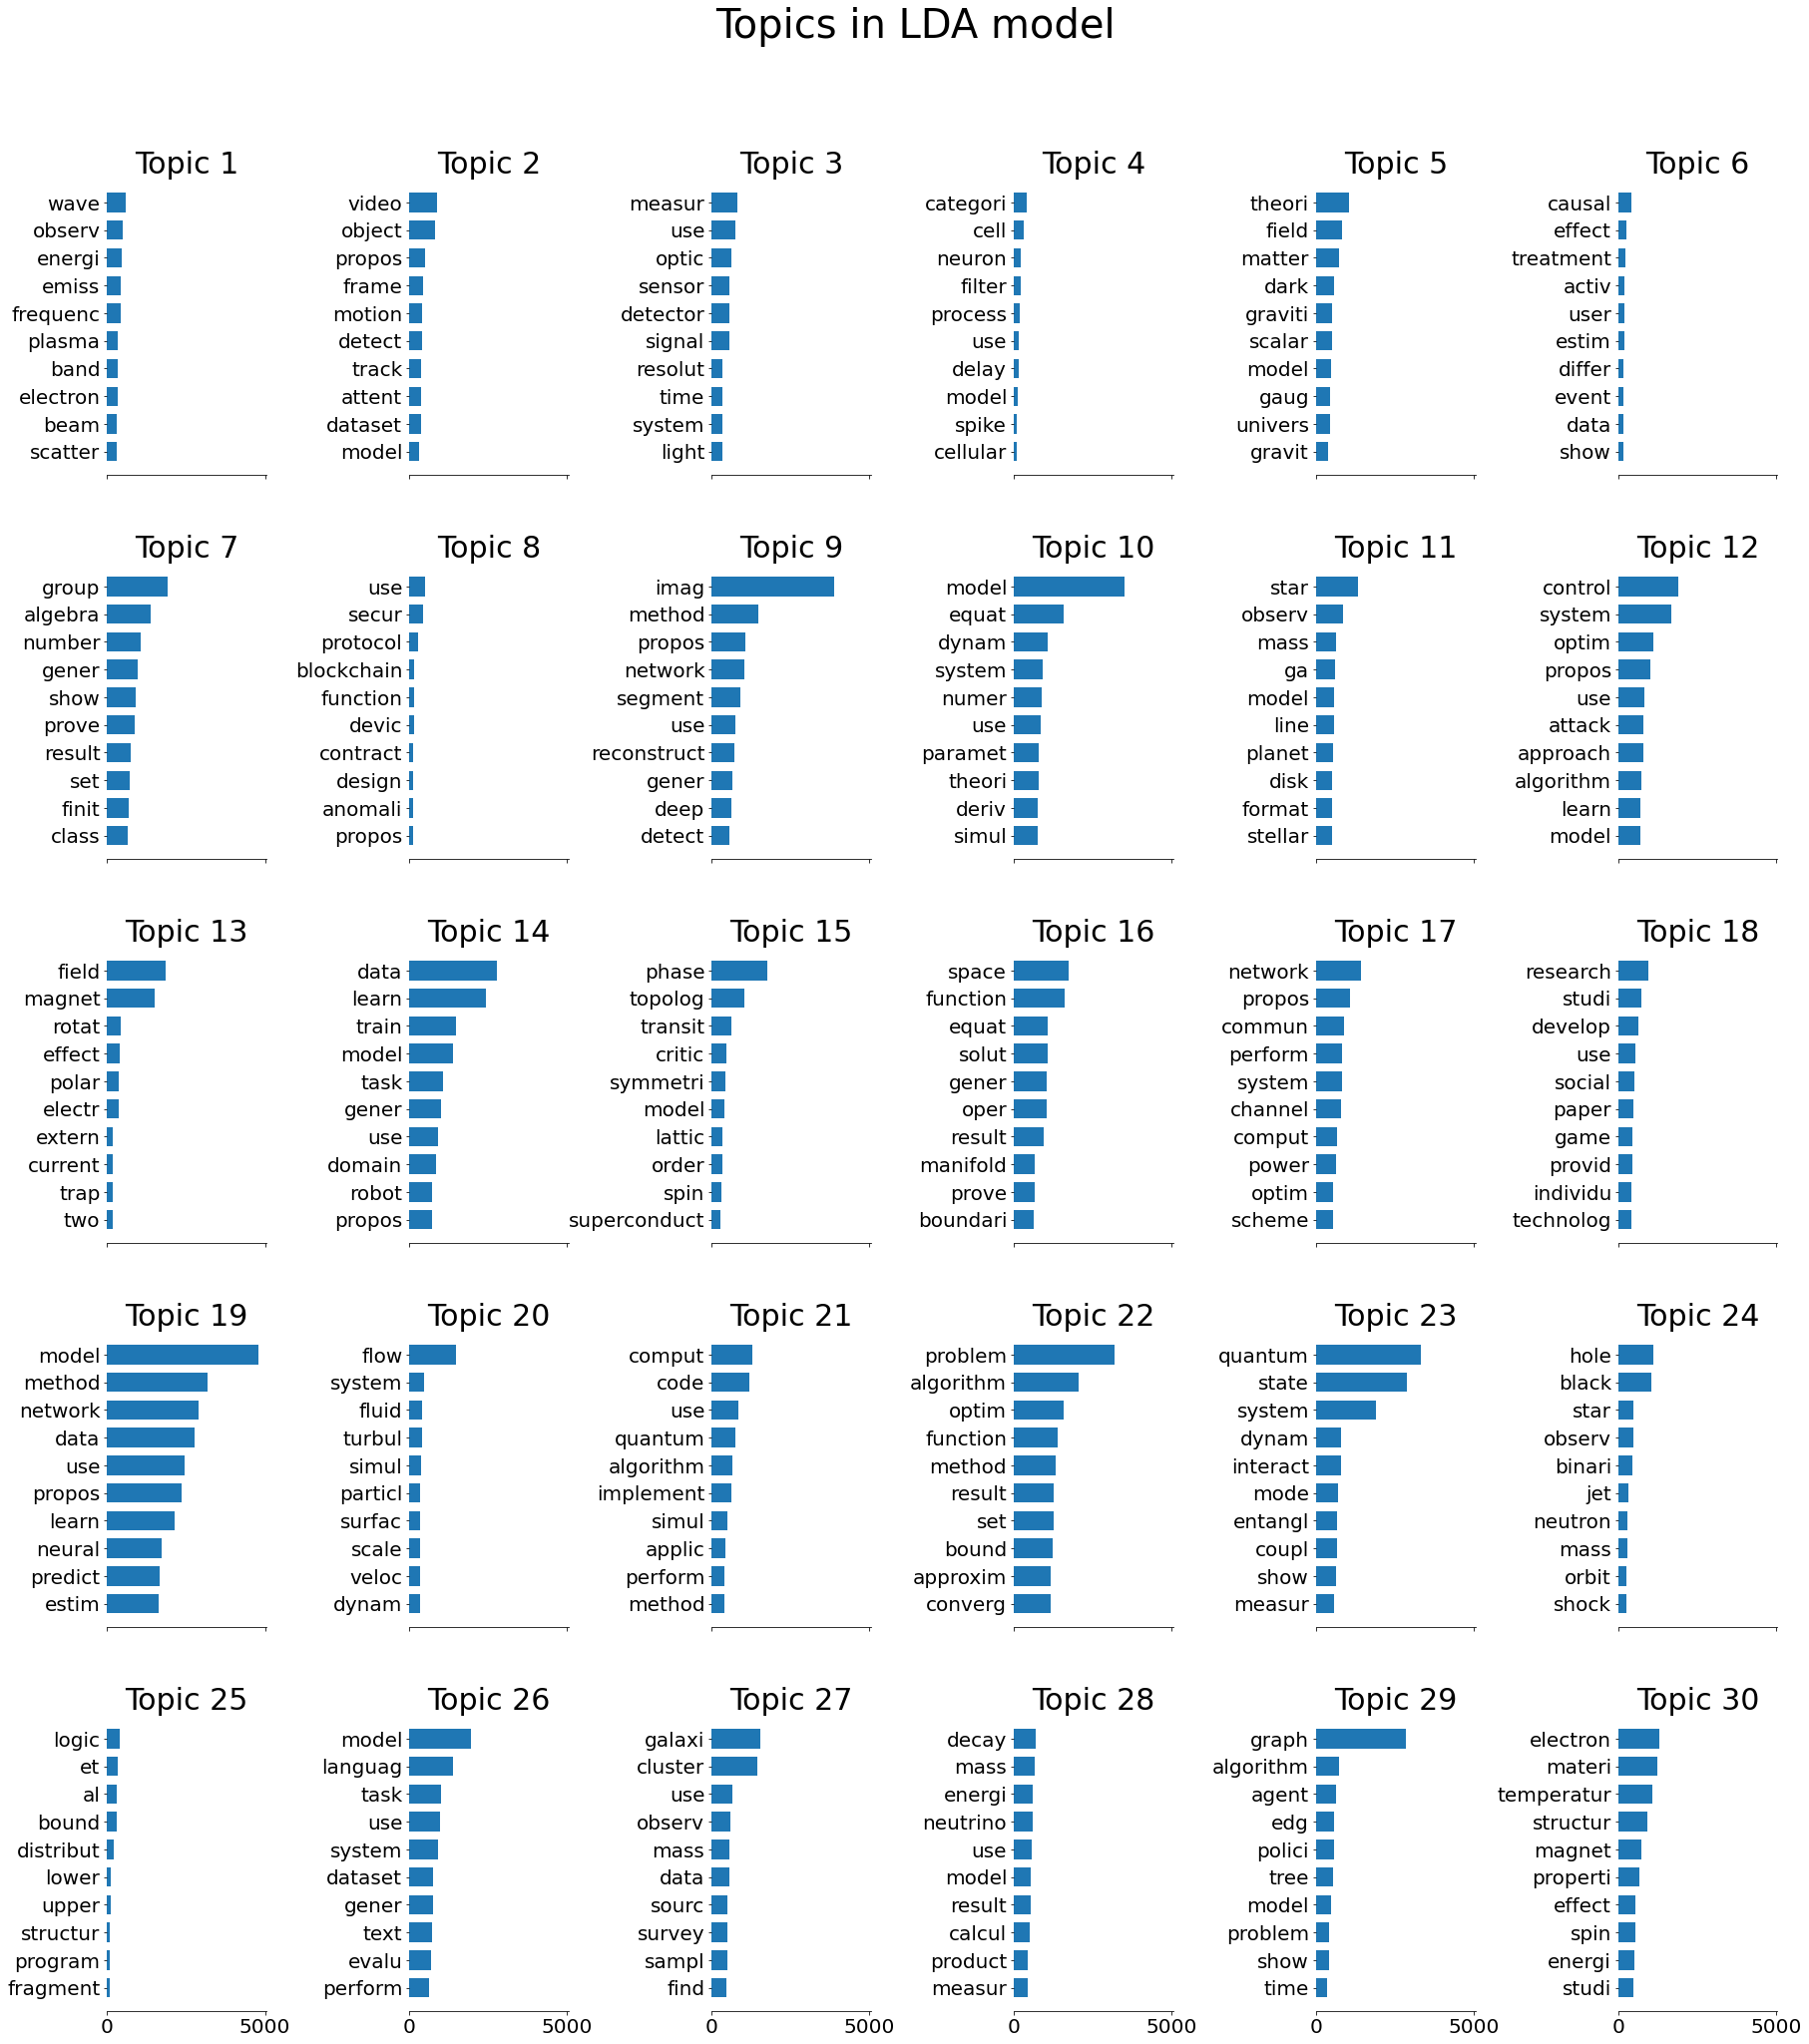

In [ ]:
n_top_words = 10
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

In [ ]:
# Choose topic for document
doc_index = 3
print('\tTopic', x[doc_index].argmax())
print('\tVocab for this topic: ', )
print('\tAbstract')
print(df.abstract.iloc[doc_index])

# Top2Vec
Learning time: 781 sec  
Num of topics: 146

In [ ]:
from top2vec import Top2Vec
from time import time

data_samples = list(df.abstract)

t0 = time()
t2v = Top2Vec(data_samples)

t2v.save("t2v")
t2v = Top2Vec.load("t2v")

print(f'Top2Vec on D2V fitting is done. Time elapsed: {time() - t0} seconds')


2022-02-16 11:56:26,155 - top2vec - INFO - Pre-processing documents for training
2022-02-16 11:56:37,215 - top2vec - INFO - Creating joint document/word embedding
2022-02-16 12:08:30,913 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-02-16 12:09:20,139 - top2vec - INFO - Finding dense areas of documents
2022-02-16 12:09:23,932 - top2vec - INFO - Finding topics


Top2Vec on D2V fitting is done. Time elapsed: 781.2284972667694 seconds


In [ ]:
print('Topic counts for T2V on D2V embedding: ', t2v.get_num_topics())

Topic counts for T2V on D2V embedding:  146


In [ ]:
# return the topics in decreasing size
topic_words, word_scores, topic_nums = t2v.get_topics()

# let's look at the first (0) topic
topic_words[0], word_scores[0]

(array(['cohomology', 'algebraic', 'algebras', 'projective', 'varieties',
        'sheaves', 'holomorphic', 'manifolds', 'algebra', 'isomorphic',
        'theorem', 'torsion', 'finitely', 'hodge', 'mathbb', 'homotopy',
        'nilpotent', 'functor', 'galois', 'quotient', 'algebraically',
        'invariants', 'adic', 'let', 'symplectic', 'moduli', 'subgroup',
        'isomorphism', 'lie', 'automorphisms', 'manifold', 'calabi',
        'group', 'functors', 'commutative', 'homology', 'groups',
        'subgroups', 'bundle', 'genus', 'ahler', 'ideals', 'irreducible',
        'abelian', 'mathfrak', 'automorphism', 'yau', 'gromov', 'bundles',
        'spaces'], dtype='<U15'),
 array([0.56272215, 0.5363314 , 0.53148574, 0.5203603 , 0.51510924,
        0.51144904, 0.49665788, 0.48352227, 0.48200887, 0.46598148,
        0.46586144, 0.46172976, 0.4607866 , 0.460769  , 0.45699868,
        0.45510405, 0.45159134, 0.4471519 , 0.44319826, 0.43896148,
        0.4373615 , 0.43595392, 0.4345958 , 0.4

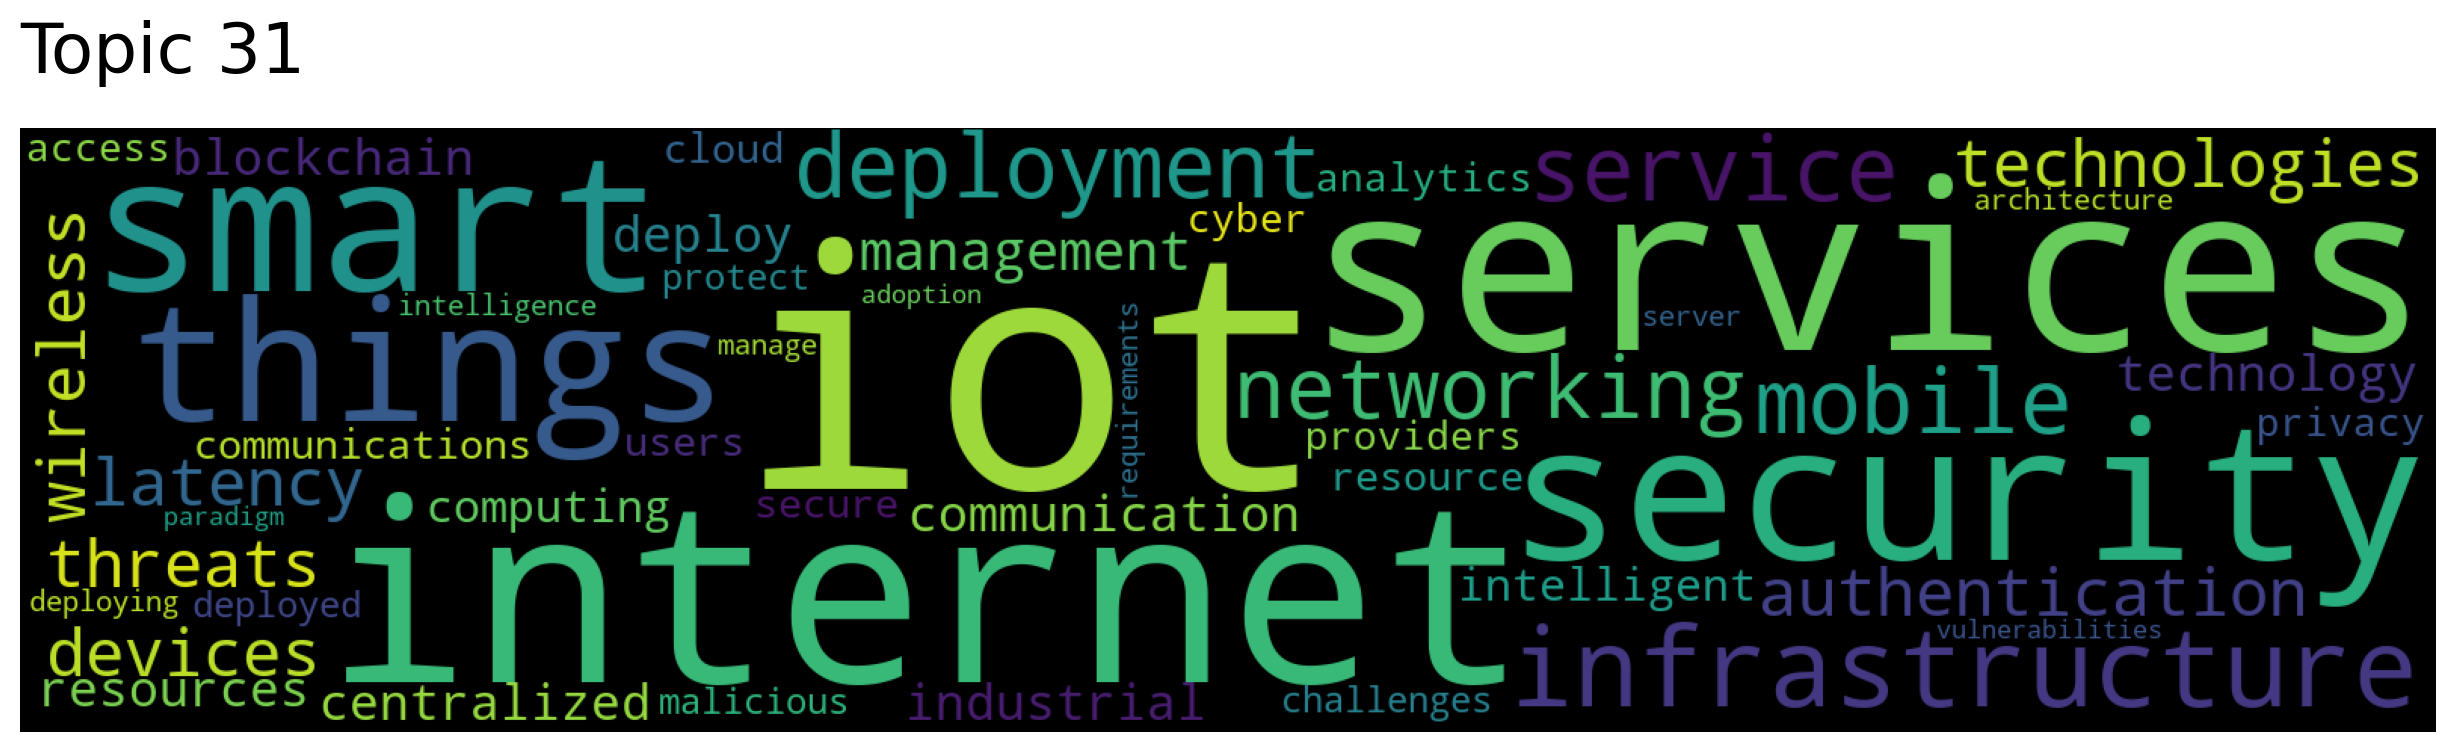

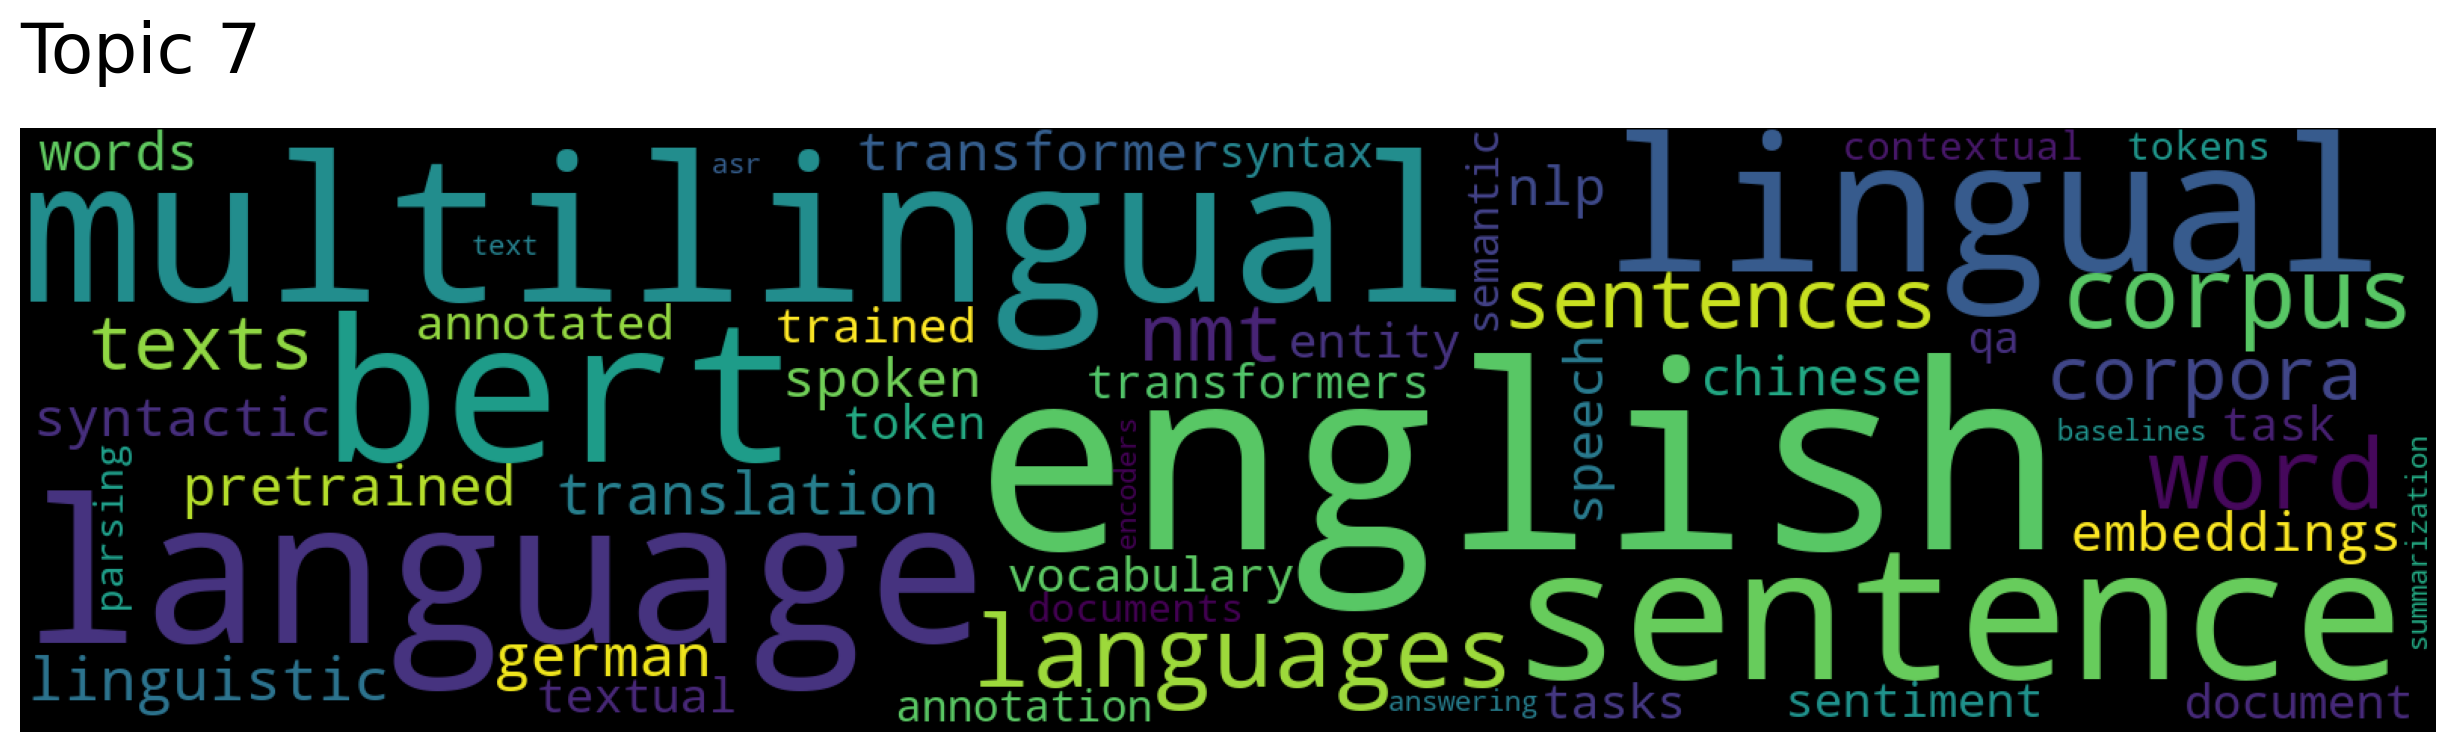

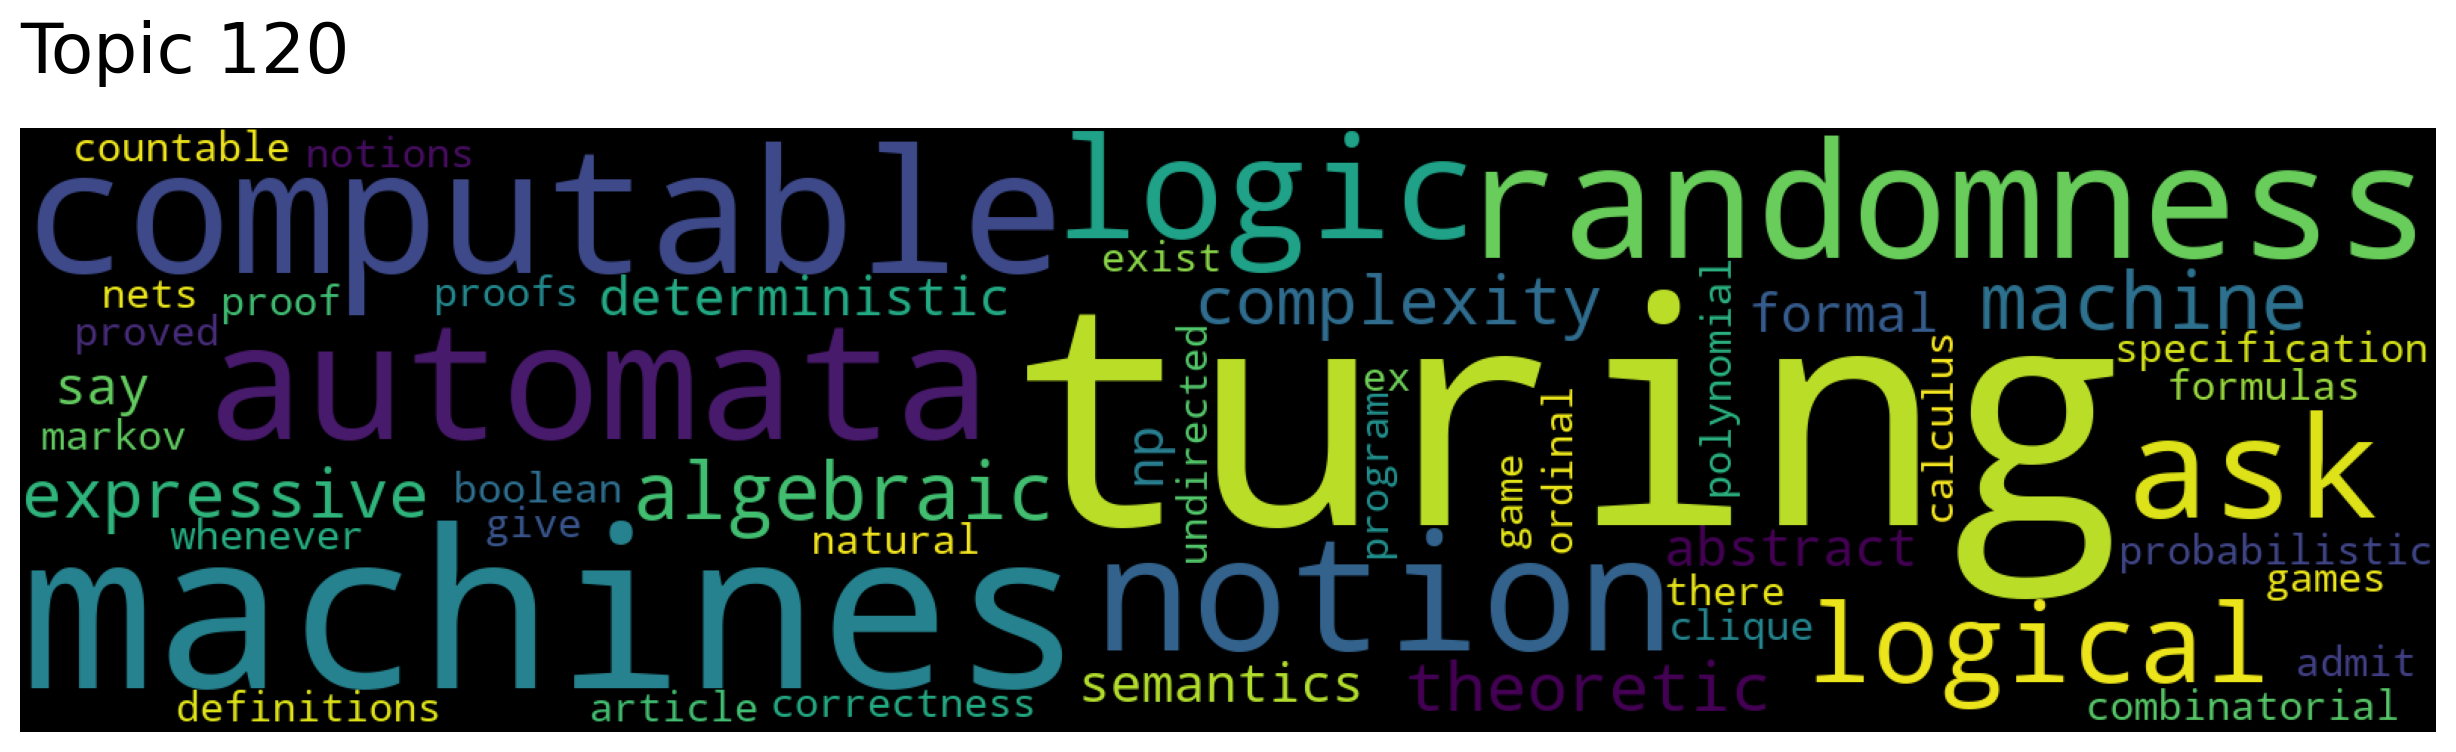

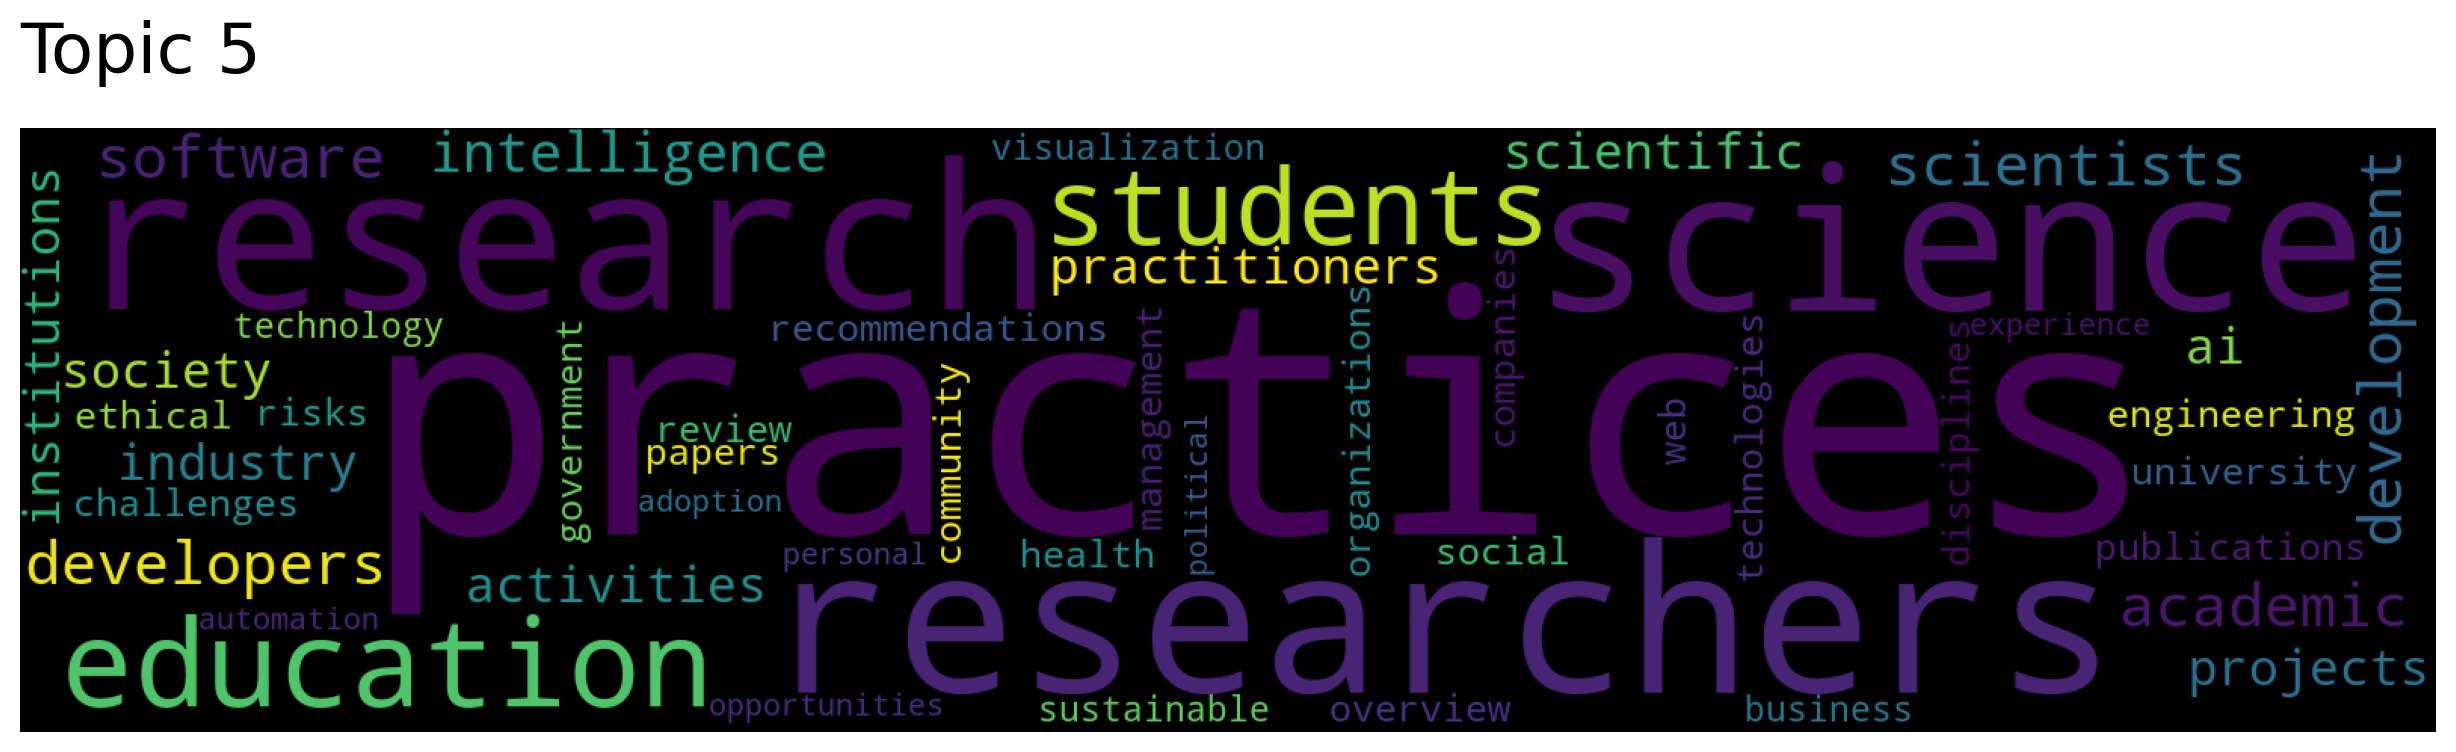

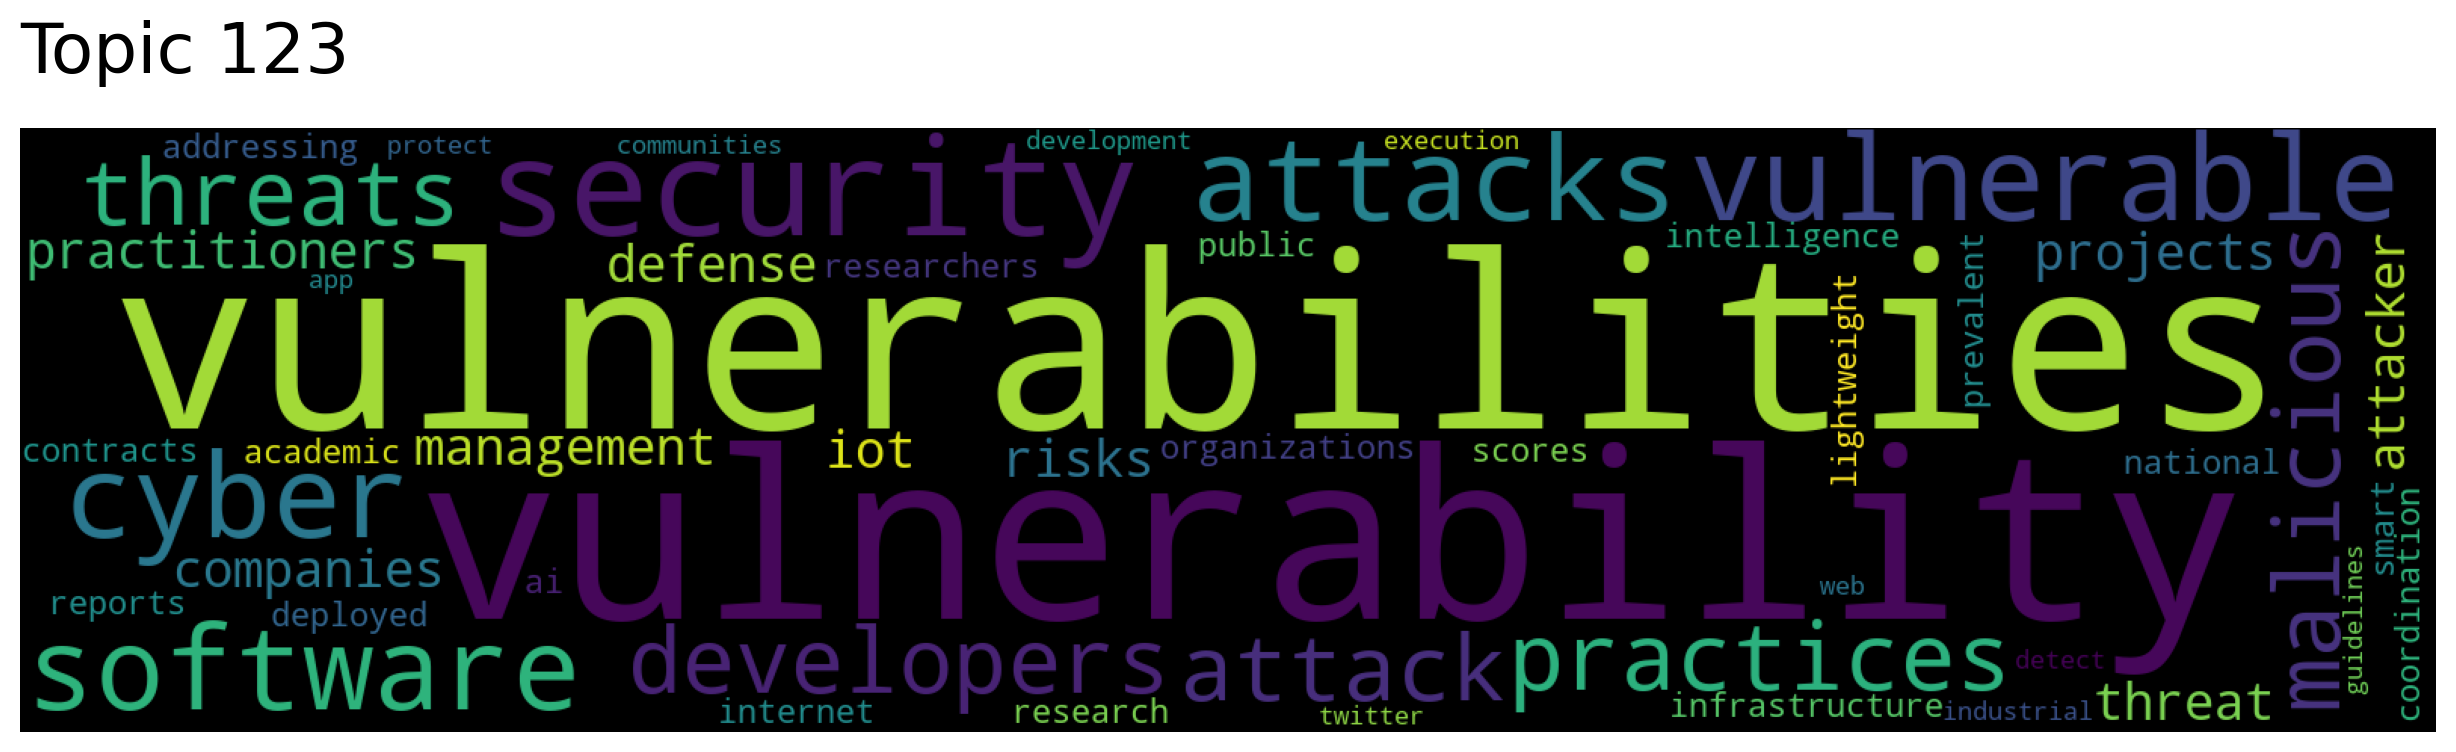

In [ ]:
# searching for topics most similar to 'machine'
topic_words, word_scores, topic_scores, topic_nums = t2v.search_topics(keywords=["machine"], num_topics=5)

# generating word clouds for the top 5 most similar topics to 'machine'
for topic in topic_nums:
    t2v.generate_topic_wordcloud(topic)

In [ ]:
# searching document by keywords
documents, document_scores, document_ids = t2v.search_documents_by_keywords(keywords=["chemistry"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 6506, Score: 0.5403217673301697
-----------
  This work describes the theoretical foundation for all quantum chemistry
functionality in PennyLane, a quantum computing software library specializing
in quantum differentiable programming. We provide an overview of fundamental
concepts in quantum chemistry, including the basic principles of the
Hartree-Fock method. A flagship feature in PennyLane is the differentiable
Hartree-Fock solver, allowing users to compute exact gradients of molecular
Hamiltonians with respect to nuclear coordinates and basis set parameters.
PennyLane provides specialized operations for quantum chemistry, including
excitation gates as Givens rotations and templates for quantum chemistry
circuits. Moreover, built-in simulators exploit sparse matrix techniques for
representing molecular Hamiltonians that lead to fast simulation for quantum
chemistry applications. In combination with PennyLane's existing methods for
constructing, optimizing, and executing ci

In [ ]:
# searching documents for Topic 1
documents, document_scores, document_ids = t2v.search_documents_by_topic(topic_num=1, num_docs=5)

for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 4458, Score: 0.6771718859672546
-----------
  We define a three-dimensional quantum theory of gravity as the holographic
dual of the Liouville conformal field theory. The theory is consistent and
unitary by definition. The corresponding theory of gravity with negative
cosmological constant has peculiar properties. The quantum theory has no
normalisable AdS3 vacuum. The model contains primary black holes with zero
spin. All states can be interpreted as black holes dressed with boundary
gravitons. There is a unique universal interaction between these states
consistent with unitarity and the conformal symmetry of the model. This theory
of gravity, though conceptually isolated from other models of quantum gravity,
is worth scrutinising.

-----------

Document: 12912, Score: 0.6751391291618347
-----------
  We investigate the thermodynamics and stability of the horizons in warped
anti-de Sitter black holes of the new massive gravity under the scattering of a
massive scalar field. 

In [ ]:
# searching most similar words
words, word_scores = t2v.similar_words(keywords=["biology"], keywords_neg=[], num_words=20)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

biological 0.3658314513626798
sciences 0.36526919099646316
disciplines 0.33297340568020606
cell 0.322659360021918
gene 0.30407339626222873
physics 0.29978049084560454
science 0.2909134451050203
important 0.28913477543766064
tumor 0.2859397592806179
cells 0.2830718639671719
microscopic 0.277323793918803
mathematics 0.2764864268397468
cancer 0.2753079082297252
highly 0.2689186267975666
advances 0.268176941738432
genetic 0.26641061490928464
protein 0.26480739862327696
mathematical 0.26454178118341765
many 0.2635934179360304
tissue 0.262789326441346


# LSA
Learning time: 6sec  
Num of topics: 5 (manually configured; optimal number finded by the highest coherence score)

In [ ]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd

data_samples = df.abstract

In [ ]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [ ]:
def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [ ]:
preprocess_text = preprocess_data(data_samples)
dictionary, dict_term_matrix = prepare_corpus(preprocess_text)

t0=time()
model = create_gensim_lsa_model(preprocess_text, number_of_topics=30, words=20)
print(f'LSA is done. Time elapsed: {time() - t0}')


[(0, '0.321*"model" + 0.245*"use" + 0.167*"data" + 0.163*"method" + 0.148*"propos" + 0.145*"result" + 0.137*"gener" + 0.136*"base" + 0.130*"system" + 0.129*"time" + 0.129*"learn" + 0.124*"show" + 0.117*"network" + 0.114*"1" + 0.106*"perform" + 0.102*"two" + 0.102*"state" + 0.100*"studi" + 0.097*"problem" + 0.096*"approach"'), (1, '-0.356*"1" + -0.290*"n" + -0.284*"2" + 0.248*"model" + -0.220*"0" + 0.195*"learn" + -0.149*"k" + 0.146*"propos" + -0.141*"x" + 0.140*"network" + 0.140*"data" + 0.135*"method" + 0.126*"train" + -0.120*"p" + -0.118*"3" + -0.105*"r" + -0.100*"_" + -0.095*"g" + -0.095*"mathbb" + 0.092*"perform"'), (2, '-0.366*"model" + 0.307*"n" + 0.180*"algorithm" + 0.178*"learn" + 0.173*"graph" + 0.153*"network" + 0.153*"problem" + -0.150*"field" + 0.146*"method" + -0.137*"observ" + 0.130*"1" + 0.127*"k" + -0.126*"system" + 0.124*"propos" + -0.121*"mass" + -0.120*"magnet" + 0.118*"g" + -0.116*"energi" + -0.106*"quantum" + 0.097*"imag"'), (3, '0.682*"model" + -0.240*"system" + 0

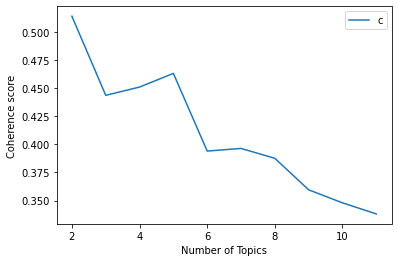

In [ ]:
# searching optimal number of topics (5)
start,stop,step= 2, 12, 1

plot_graph(preprocess_text, start, stop, step)

In [ ]:
preprocess_text = preprocess_data(data_samples)
dictionary, dict_term_matrix = prepare_corpus(preprocess_text)
number_topic = 5

t0=time()
model = create_gensim_lsa_model(preprocess_text, number_of_topics=number_topic, words=20)
print(f'LSA is done. Time elapsed: {time() - t0}')


[(0, '0.321*"model" + 0.245*"use" + 0.167*"data" + 0.163*"method" + 0.148*"propos" + 0.145*"result" + 0.137*"gener" + 0.136*"base" + 0.130*"system" + 0.129*"time" + 0.129*"learn" + 0.124*"show" + 0.117*"network" + 0.114*"1" + 0.106*"perform" + 0.102*"two" + 0.102*"state" + 0.100*"studi" + 0.097*"problem" + 0.096*"approach"'), (1, '0.356*"1" + 0.290*"n" + 0.284*"2" + -0.248*"model" + 0.220*"0" + -0.194*"learn" + 0.149*"k" + -0.146*"propos" + 0.140*"x" + -0.140*"network" + -0.140*"data" + -0.135*"method" + -0.125*"train" + 0.120*"p" + 0.118*"3" + 0.105*"r" + 0.100*"_" + 0.095*"mathbb" + 0.095*"g" + -0.092*"perform"'), (2, '0.366*"model" + -0.307*"n" + -0.180*"algorithm" + -0.178*"learn" + -0.173*"graph" + -0.154*"network" + -0.153*"problem" + 0.150*"field" + -0.146*"method" + 0.137*"observ" + -0.130*"1" + -0.127*"k" + 0.126*"system" + -0.123*"propos" + 0.122*"mass" + 0.120*"magnet" + -0.118*"g" + 0.117*"energi" + 0.106*"quantum" + -0.097*"imag"'), (3, '0.682*"model" + -0.240*"system" + 0

# BERTopic  
paraphrase-MiniLM-L12-v2  
Learning time: 332 sec  
Num of topics: 58

albert-base-v2  
Learning time: 408 sec (381 on clean)  
Num of topics: 60 (48 on clean)  

all-roberta-large-v1  
Learning time: 2054 sec  
Num of topics: 55  
  
  SentenceTransformer('sentence-transformers/all-distilroberta-v1')  
Learning time: 502 sec  
Num of topics: 50 

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from transformers import RobertaTokenizer
from flair.embeddings import TransformerDocumentEmbeddings
import tensorflow_hub
import gensim.downloader as api

data_samples = list(df.clean_abstract)

# # EMBEDDING MODELS
# #  You can select any model from sentence-transformers here and pass it through BERTopic 
# classic = "paraphrase-MiniLM-L12-v2"

# # Flair allows you to choose almost any embedding model that is publicly available:
# roberta = 'sentence-transformers/all-roberta-large-v1'
albert = 'sentence-transformers/paraphrase-albert-base-v2'
# roberta_st =  SentenceTransformer('sentence-transformers/all-distilroberta-v1')

# # The Universal Sentence Encoder encodes text into high-dimensional vectors that are used here 
# # for embedding the documents. The model is trained and optimized for greater-than-word length text, 
# # such as sentences, phrases, or short paragraphs.
# universal_sentence_encoder = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# #  BERTopic supports the gensim.downloader module, which allows it to download any word 
# #  embedding model supported by Gensim. Typically, these are Glove, Word2Vec, or FastText embeddings:
# ft = api.load('fasttext-wiki-news-subwords-300')

bertopic_onclean = BERTopic(embedding_model=albert, 
                    min_topic_size=30)

Some weights of the model checkpoint at nghuyong/ernie-2.0-en were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from time import time

t0 = time()
topics, _ = bertopic_onclean.fit_transform(data_samples)
print(f'BERTopic is done. Time elapsed: {time()-t0}')


HTTPError: ignored

In [ ]:
# import torch
# torch.save(bertopic, 'BERTopic-fasttext')
# # saved_model = torch.load('path/to/model')

In [ ]:
print(len(bertopic_onclean.get_topic_info()))
bertopic_onclean.get_topic_info().head(10)

In [ ]:
bertopic_onclean.visualize_barchart(top_n_topics=20, height=150)

In [ ]:
 bertopic_onclean.visualize_topics()

In [ ]:
# classes = [i for i in df["category"]]

# # Create topic model and calculate topics per class
# topics_per_class = bertopic.topics_per_class(data_samples, topics, classes=df.category)

In [ ]:
# bertopic.visualize_topics_per_class(topics_per_class)

# Contextualized Topic Models and Kitty  
Learning time: __ sec  
Num of topics: 50 (manualy)  
!!! Adv: support Cross-Lingual Classification

In [ ]:
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation

qt = TopicModelDataPreparation("paraphrase-distilroberta-base-v2")

training_dataset = qt.fit(text_for_contextual=list(df.abstract), 
                          text_for_bow=list(df.clean_abstract))

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from contextualized_topic_models.models.ctm import CombinedTM

ctm = CombinedTM(bow_size=len(qt.vocab), 
                 contextual_size=768, 
                 n_components=50) # 50 topics
ctm.fit(training_dataset) # run the model

In [ ]:
ctm.get_topics(5)

defaultdict(list,
            {0: ['research', 'develop', 'softwar', 'project', 'student'],
             1: ['control', 'system', 'simul', 'comput', 'design'],
             2: ['observ', 'radio', 'sourc', 'mission', 'spectral'],
             3: ['puls', 'laser', 'caviti', 'photon', 'beam'],
             4: ['curv', 'group', 'finit', 'ring', 'seri'],
             5: ['materi', 'optic', 'here', 'probe', 'devic'],
             6: ['channel', 'commun', 'power', 'rate', 'mimo'],
             7: ['imag', 'semant', 'shape', 'featur', 'video'],
             8: ['data', 'model', 'predict', 'differ', 'machin'],
             9: ['vertic', 'everi', 'denot', 'vertex', 'least'],
             10: ['classif', 'use', 'deep', 'segment', 'diagnosi'],
             11: ['unmodel', 'lookup', 'elegantli', 'instantli', 'outweigh'],
             12: ['speech', 'speaker', 'languag', 'word', 'recognit'],
             13: ['regular', 'function', 'approxim', 'filter', 'kernel'],
             14: ['hawk', 'holograp

In [ ]:
# predicting
testing_dataset = qt.transform(text_for_contextual=list(df.abstract), 
                               text_for_bow=list(df.clean_abstract))

# n_sample how many times to sample the distribution (see the doc)
ctm.get_doc_topic_distribution(testing_dataset, n_samples=20) # returns a (n_documents, n_topics) matrix with the topic distribution of each document

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling: [20/20]: : 20it [01:51,  5.56s/it]


array([[0.0061003 , 0.00690487, 0.16707148, ..., 0.00349808, 0.04742346,
        0.00549912],
       [0.00235361, 0.00244661, 0.00417086, ..., 0.01265608, 0.00339641,
        0.00382752],
       [0.00274307, 0.00125947, 0.00269627, ..., 0.00282587, 0.00714884,
        0.02741258],
       ...,
       [0.02226662, 0.01298669, 0.02099116, ..., 0.00917153, 0.01072393,
        0.03497208],
       [0.00908329, 0.01179581, 0.01135529, ..., 0.00646978, 0.00374447,
        0.00433496],
       [0.38741258, 0.0063366 , 0.01572045, ..., 0.0084967 , 0.0079935 ,
        0.01047196]])

In [ ]:
from contextualized_topic_models.models.kitty_classifier import Kitty
import numpy as np

kt = Kitty()
kt.train(list(df.clean_abstract), topics=50, embedding_model="paraphrase-distilroberta-base-v2")


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: [10/10]	 Seen Samples: [100000/100000]	Train Loss: 583.672857421875	Time: 0:00:04.723290: : 10it [00:47,  4.72s/it]
Sampling: [20/20]: : 20it [01:32,  4.63s/it]


In [ ]:
print(kt.pretty_print_word_classes())

0	group, finit, manifold, defin, space
1	mass, observ, the, differ, decay
2	magnet, electron, materi, state, spin
3	realist, neuron, diagnosi, fidel, fewer
4	the, use, simul, measur, energi
5	estim, galaxi, paramet, distribut, we
6	model, network, propos, data, predict
7	dataset, imag, learn, task, represent
8	galaxi, we, mass, observ, present
9	group, let, defin, connect, prove
10	dataset, learn, imag, perform, task
11	greatli, substanti, diagnosi, fals, seek
12	imag, train, method, data, network
13	imag, learn, dataset, train, method
14	observ, star, detect, we, measur
15	learn, network, gener, train, propos
16	system, comput, network, quantum, use
17	model, estim, data, method, use
18	use, system, network, comput, perform
19	electron, phase, transit, quantum, magnet
20	graph, show, gener, space, result
21	problem, algorithm, optim, solv, approxim
22	theori, scalar, gravit, black, hole
23	algorithm, method, optim, problem, estim
24	solut, field, hole, black, scalar
25	problem, algori

In [ ]:
kt.predict(["the village of Puza is a very nice village in Italy", "Pussetto is a soccer player that currently plays for Udiense Calcio"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling: [20/20]: : 20it [00:04,  4.26it/s]


['other', 'other']

In [ ]:
kt.widget_annotation()

Text(value='', description='0 -  group, finit, manifold, defin, space, equival, give, theorem, lie, symmetr', …

Text(value='', description='1 -  mass, observ, the, differ, decay, measur, effect, energi, paramet, we', layou…

Text(value='', description='2 -  magnet, electron, materi, state, spin, current, temperatur, atom, phase, expe…

Text(value='', description='3 -  realist, neuron, diagnosi, fidel, fewer, nonparametr, throughout, greatli, wh…

Text(value='', description='4 -  the, use, simul, measur, energi, model, process, paramet, estim, rate', layou…

Text(value='', description='5 -  estim, galaxi, paramet, distribut, we, cluster, function, sampl, equat, asymp…

Text(value='', description='6 -  model, network, propos, data, predict, learn, perform, neural, train, method'…

Text(value='', description='7 -  dataset, imag, learn, task, represent, propos, video, featur, visual, scene',…

Text(value='', description='8 -  galaxi, we, mass, observ, present, sampl, find, stellar, veloc, spectroscop',…

Text(value='', description='9 -  group, let, defin, connect, prove, everi, algebra, vertic, theorem, manifold'…

Text(value='', description='10 -  dataset, learn, imag, perform, task, network, propos, data, improv, inform',…

Text(value='', description='11 -  greatli, substanti, diagnosi, fals, seek, expens, migrat, waveform, adjust, …

Text(value='', description='12 -  imag, train, method, data, network, deep, propos, use, label, learn', layout…

Text(value='', description='13 -  imag, learn, dataset, train, method, propos, data, perform, model, network',…

Text(value='', description='14 -  observ, star, detect, we, measur, mass, the, find, time, period', layout=Lay…

Text(value='', description='15 -  learn, network, gener, train, propos, neural, task, perform, deep, adversari…

Text(value='', description='16 -  system, comput, network, quantum, use, sensor, technolog, deploy, applic, us…

Text(value='', description='17 -  model, estim, data, method, use, approach, predict, propos, base, covari', l…

Text(value='', description='18 -  use, system, network, comput, perform, data, design, deploy, requir, provid'…

Text(value='', description='19 -  electron, phase, transit, quantum, magnet, superconduct, here, temperatur, s…

Text(value='', description='20 -  graph, show, gener, space, result, we, number, set, theorem, algebra', layou…

Text(value='', description='21 -  problem, algorithm, optim, solv, approxim, polici, minim, constraint, agent,…

Text(value='', description='22 -  theori, scalar, gravit, black, hole, coupl, particl, chiral, symmetri, wave'…

Text(value='', description='23 -  algorithm, method, optim, problem, estim, comput, effici, control, system, p…

Text(value='', description='24 -  solut, field, hole, black, scalar, theori, equat, graviti, matter, gravit', …

Text(value='', description='25 -  problem, algorithm, optim, solut, approxim, bound, method, condit, comput, s…

Text(value='', description='26 -  quantum, system, comput, state, method, circuit, optim, control, propos, sim…

Text(value='', description='27 -  group, algebra, graph, finit, construct, prove, theorem, show, isomorph, equ…

Text(value='', description='28 -  model, learn, data, perform, propos, predict, neural, dataset, network, task…

Text(value='', description='29 -  problem, algorithm, set, optim, comput, bound, graph, time, number, result',…

Text(value='', description='30 -  algorithm, problem, optim, agent, polici, game, achiev, constraint, environ,…

Text(value='', description='31 -  magnet, spin, field, temperatur, electron, transit, state, atom, structur, p…

Text(value='', description='32 -  quantum, equat, theori, system, state, classic, function, deriv, space, scal…

Text(value='', description='33 -  space, relat, theori, invari, theorem, equat, prove, solut, boundari, constr…

Text(value='', description='34 -  equilibrium, scientif, climat, return, drift, intellig, regul, adjust, behav…

Text(value='', description='35 -  we, star, observ, disk, find, galaxi, stellar, mass, accret, orbit', layout=…

Text(value='', description='36 -  learn, network, neural, train, perform, propos, model, adversari, approach, …

Text(value='', description='37 -  languag, work, social, research, develop, user, visual, inform, speech, ai',…

Text(value='', description='38 -  bayesian, drug, belief, crowd, adjust, wherea, neuron, diagnosi, damag, igno…

Text(value='', description='39 -  learn, imag, object, propos, task, dataset, method, visual, gener, perform',…

Text(value='', description='40 -  observ, the, emiss, energi, magnet, high, neutron, temperatur, line, plasma'…

Text(value='', description='41 -  use, model, data, predict, observ, the, differ, measur, estim, studi', layou…

Text(value='', description='42 -  optic, laser, electron, here, photon, crystal, high, film, demonstr, puls', …

Text(value='', description='43 -  control, servic, commun, system, iot, secur, requir, paper, blockchain, reso…

Text(value='', description='44 -  state, phase, effect, quantum, particl, system, the, differ, dynam, field', …

Text(value='', description='45 -  quantum, state, field, phase, spin, magnet, interact, entangl, symmetri, sys…

Text(value='', description='46 -  belief, surround, fals, greatli, diagnosi, commonli, fidel, neuron, waveform…

Text(value='', description='47 -  data, use, model, base, dataset, evalu, inform, estim, test, predict', layou…

Text(value='', description='48 -  develop, task, challeng, video, user, learn, human, system, design, visual',…

Text(value='', description='49 -  star, astrophys, detector, event, binari, cosmic, search, supernova, neutrin…

Button(description='Save', style=ButtonStyle(button_color='lightgreen'))

# StructBERT

In [ ]:
!wget https://raw.githubusercontent.com/alibaba/AliceMind/main/StructBERT/config/large_bert_config.json && mv large_bert_config.json config.json
!wget https://raw.githubusercontent.com/alibaba/AliceMind/main/StructBERT/config/vocab.txt
!wget https://alice-open.oss-cn-zhangjiakou.aliyuncs.com/StructBERT/en_model && mv en_model pytorch_model.bin

In [ ]:
from transformers import AutoConfig, AutoModelForMaskedLM, AutoTokenizer

config = AutoConfig.from_pretrained("./config.json")
model = AutoModelForMaskedLM.from_pretrained(".", config=config)
tokenizer = AutoTokenizer.from_pretrained(".", config=config)

model.push_to_hub("structbert-large")
tokenizer.push_to_hub("structbert-large")


# lda2vec
Learning time: __ sec  
Num of topics: __ 

In [ ]:
# bertopic = BERTopic(verbose=True, 
#                     embedding_model='ST-MoE-32B', 
#                     min_topic_size=30)

In [ ]:
import pyLDAvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

import pyLDAvis
movies_vis_data = pyLDAvis.prepare(data_samples)

TypeError: ignored

# Averaged Word2Vec + UMAP + Kmeans

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

data_samples = list(df.clean_abstract)
sentences = [list(abstract.split()) for abstract in data_samples]

# cores = multiprocessing.cpu_count()
# w2v_sg = Word2Vec(min_count=20,
#                      window=2,
#                      size=300,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,
#                      workers=cores-1,
#                      sg=0)


In [ ]:
# sg=0 means we use cbow model, sg=1 means Skip_gram
%time model_en = Word2Vec(sentences, workers=4, size=300, min_count=10, window=10, sample=1e-3)


In [ ]:
example = sentences[0]
for i in example:
    document_vector = sum([np.array(model_en[word] for word in example])
document_vector

# document_vectors = []
# for i in sentences:
#   for i in example:
#     vector = sum([np.array(model_en[word] for word in example])
#   document_vectors.append(vector)